In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0, DenseNet121, InceptionV3, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings(
    "ignore",
    message=r"Your `PyDataset` class should call `super\(\).__init__\(\*\*kwargs\)` in its constructor\."
)

Dataset structure:
train/: ['paper', 'rock', 'scissors']
validation/: ['paper', 'rock', 'scissors']
test/: ['paper', 'rock', 'scissors']
train/paper: 498 images
train/rock: 508 images
train/scissors: 525 images
validation/paper: 107 images
validation/rock: 109 images
validation/scissors: 112 images
test/paper: 107 images
test/rock: 109 images
test/scissors: 113 images

Total images: 2188


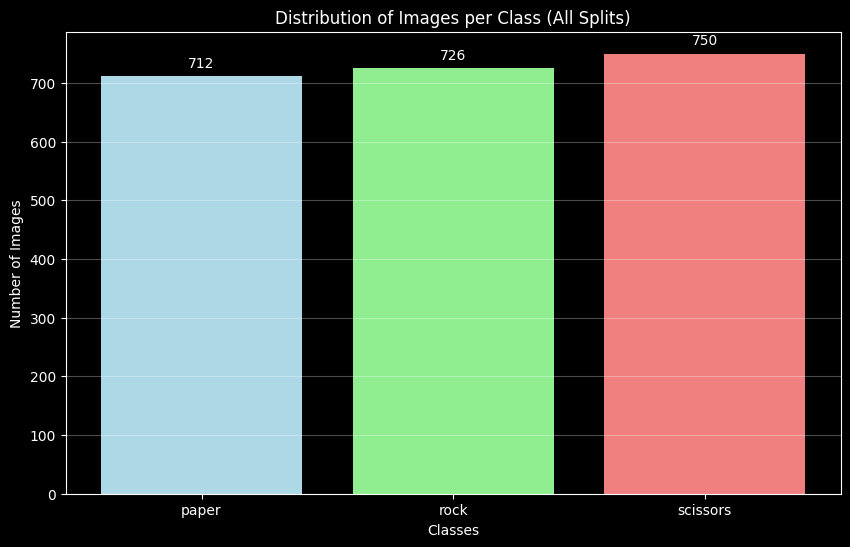

In [2]:
# Dataset configuration (updated for new structure)
base_path = r'../image-dataset/rockpaperscissors/rps-cv-images'
splits = ['train', 'validation', 'test']
classes = ['paper', 'rock', 'scissors']

print("Dataset structure:")
for split in splits:
    split_path = os.path.join(base_path, split)
    print(f"{split}/: {os.listdir(split_path)}")

# Count images in each class across all splits
class_counts = {cls: 0 for cls in classes}
total_images = 0

for split in splits:
    for class_name in classes:
        class_path = os.path.join(base_path, split, class_name)
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] += count
            total_images += count
            print(f"{split}/{class_name}: {count} images")

print(f"\nTotal images: {total_images}")

# Visualize class distribution (total across all splits)
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Images per Class (All Splits)')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values()):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

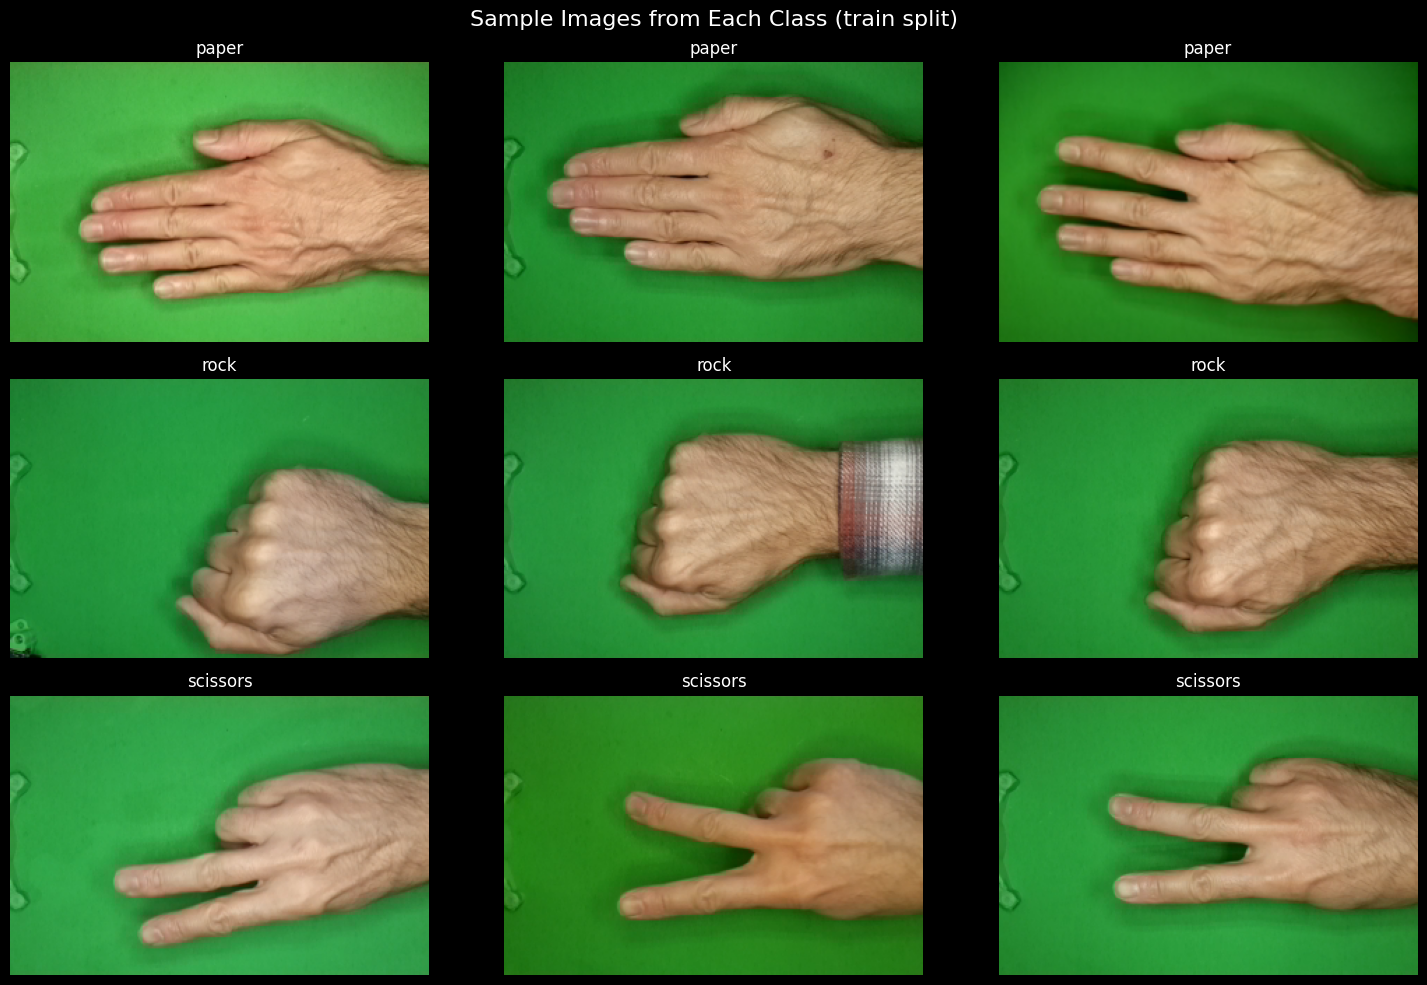

In [3]:
# Display sample images from each class (from train split)
def display_sample_images(base_path, classes, samples_per_class=3, split='train'):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 10))
    fig.suptitle(f'Sample Images from Each Class ({split} split)', fontsize=16)

    for i, class_name in enumerate(classes):
        class_path = os.path.join(base_path, split, class_name)
        image_files = os.listdir(class_path)[:samples_per_class]

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(image)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(base_path, classes)

In [ ]:
# Data Pipeline Using tf.data
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Define dataset paths
train_path = os.path.join(base_path, 'train')
validation_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

# Create datasets from directories
def get_dataset(path, shuffle, seed=42):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=seed
    )

train_ds = get_dataset(train_path, shuffle=True)
val_ds = get_dataset(validation_path, shuffle=False)
test_ds = get_dataset(test_path, shuffle=False)

# Data augmentation block (no rescaling needed)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomColorJitter(
        brightness_factor=0.2, 
        contrast_factor=0.2, 
        saturation_factor=0.2, 
        hue_factor=0.1
    ),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    tf.keras.layers.RandomGaussianBlur(kernel_size=3, factor=(0.1, 0.5))
], name="data_augmentation")

# Pipeline preparation function
def prepare(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

print("tf.data pipelines created successfully.")


Found 1531 files belonging to 3 classes.
Found 328 files belonging to 3 classes.
Found 329 files belonging to 3 classes.


ValueError: Unrecognized keyword arguments passed to RandomColorJitter: {'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.1}

In [5]:
# Custom CNN Model
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a custom CNN with best practices:
    - Batch normalization for stable training
    - Dropout for regularization
    - Global average pooling to reduce overfitting
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile custom CNN
custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Custom CNN total parameters: {custom_cnn.count_params():,}")

Custom CNN total parameters: 1,309,347


In [6]:
# Transfer Learning Models
def create_transfer_learning_model(base_model_name='VGG16', input_shape=(224, 224, 3), num_classes=3):
    """
    Create transfer learning model with pre-trained weights
    """
    # Select base model
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}. Choose from: 'VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0', 'DenseNet121', 'InceptionV3', 'Xception'")

    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add custom classification head with preprocessing block
    model = models.Sequential([
        layers.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Create transfer learning models
print("Creating transfer learning models...")

# VGG16 Model
vgg16_model, vgg16_base = create_transfer_learning_model('VGG16')
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# MobileNetV2 Model (lighter and faster)
mobilenet_model, mobilenet_base = create_transfer_learning_model('MobileNetV2')
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# ResNet50 Model
resnet_model, resnet_base = create_transfer_learning_model('ResNet50')
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EfficientNetB0 Model
efficientnet_model, efficientnet_base = create_transfer_learning_model('EfficientNetB0')
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# DenseNet121 Model
densenet_model, densenet_base = create_transfer_learning_model('DenseNet121')
densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# InceptionV3 Model
inception_model, inception_base = create_transfer_learning_model('InceptionV3')
inception_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Xception Model
xception_model, xception_base = create_transfer_learning_model('Xception')
xception_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer learning models created successfully")
print(f"VGG16 total parameters: {vgg16_model.count_params():,}")
print(f"MobileNetV2 total parameters: {mobilenet_model.count_params():,}")
print(f"ResNet50 total parameters: {resnet_model.count_params():,}")
print(f"EfficientNetB0 total parameters: {efficientnet_model.count_params():,}")
print(f"DenseNet121 total parameters: {densenet_model.count_params():,}")
print(f"InceptionV3 total parameters: {inception_model.count_params():,}")
print(f"Xception total parameters: {xception_model.count_params():,}")

Creating transfer learning models...
Transfer learning models created successfully
VGG16 total parameters: 15,111,491
MobileNetV2 total parameters: 3,051,075
ResNet50 total parameters: 24,777,091
EfficientNetB0 total parameters: 4,842,662
DenseNet121 total parameters: 7,698,499
InceptionV3 total parameters: 22,992,163
Xception total parameters: 22,050,859


In [7]:
# Training Configuration and Callbacks
def create_callbacks(model_name):
    """Create callbacks for training"""
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when validation accuracy plateaus
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            f'../models/best_{model_name}_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks

# Training parameters
EPOCHS = 20

print("Training configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("Learning rate: 0.001")
print("Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint")

Training configuration:
Epochs: 20
Batch size: 32
Learning rate: 0.001
Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# Train and fine-tune all models
history_dict = {}
models_dict = {
    'Custom CNN': (custom_cnn, None),
    'VGG16': (vgg16_model, vgg16_base),
    'MobileNetV2': (mobilenet_model, mobilenet_base),
    'ResNet50': (resnet_model, resnet_base),
    'EfficientNetB0': (efficientnet_model, efficientnet_base),
    'DenseNet121': (densenet_model, densenet_base),
    'InceptionV3': (inception_model, inception_base),
    'Xception': (xception_model, xception_base)
}

# Train and fine-tune all models
for model_name, (model, base_model) in models_dict.items():
    print(f"\n===== Training {model_name} =====")
    if model_name == 'Custom CNN':
        history = model.fit(
            train_ds,
            epochs=EPOCHS,
            validation_data=val_ds,
            callbacks=create_callbacks('custom_cnn'),
            verbose=1
        )
        history_dict[model_name] = history
    else:
        # Initial training with frozen base model
        print(f"Initial training of {model_name}...")
        history_initial = model.fit(
            train_ds,
            epochs=min(10, EPOCHS),
            validation_data=val_ds,
            callbacks=create_callbacks(f'{model_name}_initial'),
            verbose=1
        )
        # Fine-tuning: Unfreeze some layers and train with lower learning rate
        print(f"Fine-tuning {model_name}...")
        if model_name in ['VGG16', 'ResNet50']:
            for layer in base_model.layers[-4:]:
                layer.trainable = True
        elif model_name in ['MobileNetV2', 'EfficientNetB0']:
            trainable_layers = int(len(base_model.layers) * 0.15)
            for layer in base_model.layers[-trainable_layers:]:
                layer.trainable = True
        else:
            trainable_layers = int(len(base_model.layers) * 0.1)
            for layer in base_model.layers[-trainable_layers:]:
                layer.trainable = True
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        history_fine_tune = model.fit(
            train_ds,
            epochs=EPOCHS,
            validation_data=val_ds,
            callbacks=create_callbacks(f'{model_name}_fine_tuned'),
            verbose=1
        )
        history_dict[model_name] = history_fine_tune

In [ ]:
# Show all training history plots in a grid
num_models = len(history_dict)
cols = 2
rows = math.ceil(num_models / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*4))
axes = axes.flatten() if num_models > 1 else [axes]
for idx, (model_name, history) in enumerate(history_dict.items()):
    ax1 = axes[idx]
    ax1.plot(history.history['accuracy'], label='Train Acc')
    ax1.plot(history.history['val_accuracy'], label='Val Acc')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)
    # Plot loss in a twin axis
    ax2 = ax1.twinx()
    ax2.plot(history.history['loss'], label='Train Loss', color='tab:orange', linestyle='--')
    ax2.plot(history.history['val_loss'], label='Val Loss', color='tab:red', linestyle='--')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
for j in range(idx+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Best validation accuracy for each model
print("\n===== Best Validation Accuracy for Each Model =====")
print(f"{'Model':<18} | {'Best Val Accuracy':>17}")
print('-'*38)
for model_name, history in history_dict.items():
    best_acc = max(history.history['val_accuracy'])
    print(f"{model_name:<18} | {best_acc:>17.4f}")

In [ ]:
# Model performance evaluation on unseen test data
results = []
class_names = list(train_ds.class_indices.keys())

for model_name in models_dict.keys():
    print(f"\n===== Evaluating {model_name} on Test Set =====")
    model_path = '../models/best_custom_cnn_model.keras' if model_name == 'Custom CNN' else f'../models/best_{model_name}_fine_tuned.keras'
    try:
        best_model = tf.keras.models.load_model(model_path)
    except IOError:
        print(f"Could not find model file at {model_path}. Skipping.")
        continue

    loss, accuracy = best_model.evaluate(test_ds, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")
    results.append({'Model': model_name, 'Test Accuracy': accuracy})

    predictions = best_model.predict(test_ds, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_ds.classes

    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("-" * 60)

print("\n===== Final Model Performance on Unseen Test Data =====")
results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print(results_df)